# Building a simple time series model

In [1]:
%matplotlib inline

We'll be using the international airline passenger data available from [here](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line). This particular dataset is included with `river` in the `datasets` module.

In [2]:
import pandas as pd
from river import datasets

In [3]:
for x, y in datasets.AirlinePassengers():
    print(x, y)
    break

{'month': datetime.datetime(1949, 1, 1, 0, 0)} 112


In [4]:
data = pd.Series({x["month"]: y for x, y in datasets.AirlinePassengers()})
data

1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Length: 144, dtype: int64

The data is as simple as can be: it consists of a sequence of months and values representing the total number of international airline passengers per month. 

Our goal is going to be to predict the number of passengers for the next month at each step. Notice that because the dataset is small  -- which is usually the case for time series -- we could just fit a model from scratch each month. However for the sake of example we're going to train a single model online. Although the overall performance might be potentially weaker, training a time series model online has the benefit of being scalable if, say, you have have [thousands of time series to manage](http://www.unofficialgoogledatascience.com/2017/04/our-quest-for-robust-time-series.html).

## Linear Regression onto the ordinal date 

We'll start with a very simple model where the only feature will be the [ordinal date](https://www.wikiwand.com/en/Ordinal_date) of each month. This should be able to capture some of the underlying trend. 

In [5]:
from river import compose, linear_model, preprocessing


def get_ordinal_date(x):
    return {"ordinal_date": x["month"].toordinal()}

In [6]:
for x, y in datasets.AirlinePassengers():
    print(get_ordinal_date(x))
    break

{'ordinal_date': 711493}


### Transformer 

fit(X, y) -> learn_one(x, y)
predict(X) -> predict_one(x)
transform(X) -> transform_one(x)


predict_many(X)
learn_many(X)

In [7]:
for x, y in datasets.AirlinePassengers():
    print(compose.FuncTransformer(get_ordinal_date).transform_one(x))
    break

{'ordinal_date': 711493}


### Pipeline 

In [8]:
model = compose.Pipeline(
    ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
    ("scale", preprocessing.StandardScaler()),
    ("lin_reg", linear_model.LinearRegression()),
)

### Model evaluation 

We'll write down a function to evaluate the model. This will go through each observation in the dataset and update the model as it goes on. The prior predictions will be stored along with the true values and will be plotted together. 

In [9]:
import matplotlib.pyplot as plt
from river import metrics


def evaluate_model(model):

    metric = metrics.Rolling(metrics.MAE(), 12)

    dates = []
    y_trues = []
    y_preds = []

    for x, y in datasets.AirlinePassengers():

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x["month"])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color="#2ecc71", alpha=0.8, label="Ground truth")
    ax.plot(dates, y_preds, lw=3, color="#e74c3c", alpha=0.8, label="Prediction")
    ax.legend()
    ax.set_title(metric)

Let's evaluate our first model.

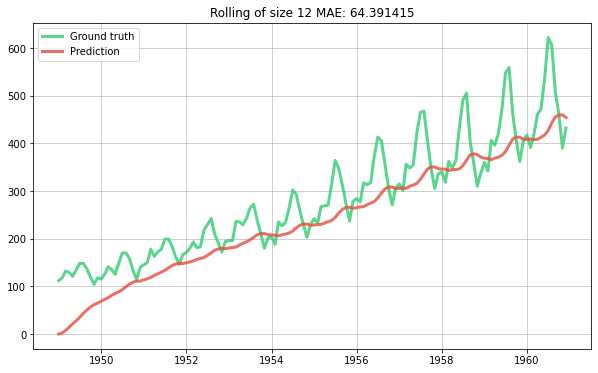

In [10]:
evaluate_model(model)

The model has captured a trend but not the right one. 

Indeed it thinks the trend is linear whereas we can visually see that **the growth of the data increases with time**. 
In other words the second derivative of the series is positive. 

This is a well know problem in time series forecasting and there are thus many ways to handle it; for example by using a [Box-Cox transform](https://www.wikiwand.com/en/Power_transform).

## Adding a Detrender wrapper

However we are going to do something a bit different, and instead **linearly detrend** the series using a `Detrender`. 

We'll set `window_size` to 12 in order to use a **rolling mean of size 12** for detrending.

The `Detrender` will center the target in 0, which means that we don't need an intercept in our linear regression. 

We can thus set `intercept_lr` to 0.

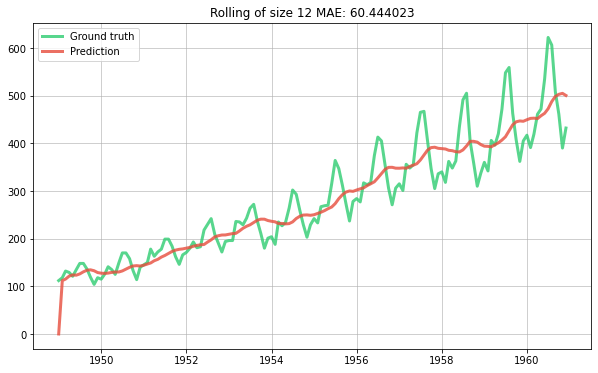

In [11]:
from river import stats, time_series

model = compose.Pipeline(
    ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
    ("scale", preprocessing.StandardScaler()),
    ("lin_reg", linear_model.LinearRegression(intercept_lr=0)),
)

model = time_series.Detrender(regressor=model, window_size=12)

evaluate_model(model)

## Capturing monthly trend 

Now let's try and capture the monthly trend by **one-hot encoding** the month name.

In [12]:
import calendar


def get_month(x):
    return {
        calendar.month_name[month]: month == x["month"].month for month in range(1, 13)
    }

In [13]:
from pprint import pprint

In [14]:
for x, y in datasets.AirlinePassengers():
    pprint(get_month(x))
    break

{'April': False,
 'August': False,
 'December': False,
 'February': False,
 'January': True,
 'July': False,
 'June': False,
 'March': False,
 'May': False,
 'November': False,
 'October': False,
 'September': False}


### Adding feature with TransformerUnion

In [15]:
for x, y in datasets.AirlinePassengers():
    pprint(
        compose.TransformerUnion(
            ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
            ("month", compose.FuncTransformer(get_month)),
        ).transform_one(x)
    )
    break

{'April': False,
 'August': False,
 'December': False,
 'February': False,
 'January': True,
 'July': False,
 'June': False,
 'March': False,
 'May': False,
 'November': False,
 'October': False,
 'September': False,
 'ordinal_date': 711493}


### Compose the model with Detrending + monthly seasonality

In [16]:
model = compose.Pipeline(
    (
        "features",
        compose.TransformerUnion(
            ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
            ("month", compose.FuncTransformer(get_month)),
        ),
    ),
    ("scale", preprocessing.StandardScaler()),
    ("lin_reg", linear_model.LinearRegression(intercept_lr=0)),
)

model = time_series.Detrender(regressor=model, window_size=12)

### Evaluate the model 

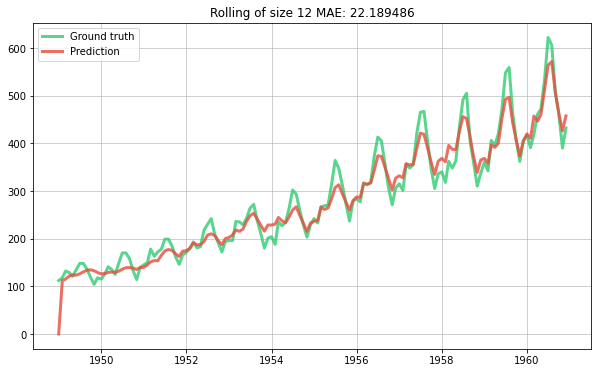

In [17]:
evaluate_model(model)

This seems pretty decent.

We can take a look at the weights of the linear regression to get an idea of the importance of each feature.

In [18]:
model.regressor["lin_reg"].weights

{'January': -9.469216150196292,
 'February': -14.616539494085554,
 'March': -3.543831579749453,
 'April': -2.766323821459067,
 'May': -0.6224556651312263,
 'June': 13.478341968972643,
 'July': 28.772701948655836,
 'August': 26.88560005378563,
 'September': 4.707302312777268,
 'October': -8.705184336916485,
 'November': -22.48440069047625,
 'December': -13.372426538578132,
 'ordinal_date': 13.829969822169433}

As could be expected the months of July and August have the highest weights because these are the months where people typically go on holiday abroad. The month of December has a low weight because this is a month of festivities in most of the Western world where people usually stay at home.

Our model seems to understand which months are important, but it fails to see that **the importance of each month grows multiplicatively as the years go on**. In other words our model is too shy. We can fix this by increasing the learning rate of the `LinearRegression`'s optimizer.

### Increasing learning rate 

In [19]:
from river import optim

model = compose.Pipeline(
    (
        "features",
        compose.TransformerUnion(
            ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
            ("month", compose.FuncTransformer(get_month)),
        ),
    ),
    ("scale", preprocessing.StandardScaler()),
    (
        "lin_reg",
        linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03)),
    ),
)

model = time_series.Detrender(regressor=model, window_size=12)

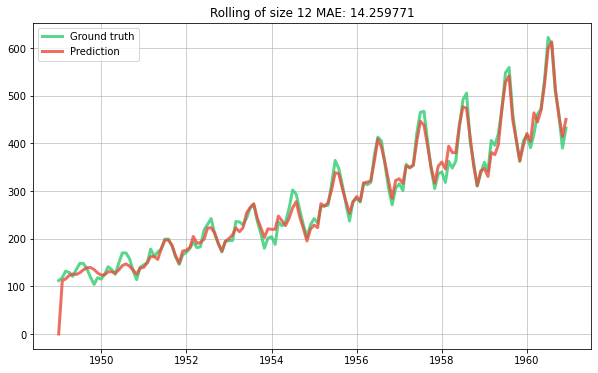

In [20]:
evaluate_model(model)

This is starting to look good! Naturally in production we would tune the learning rate, ideally in real-time.

## Using Gaussian radial basis function kernel 

Before finishing, we're going to introduce a cool feature extraction trick based on [radial basis function kernels](https://www.wikiwand.com/en/Radial_basis_function_kernel). The one-hot encoding we did on the month is a good idea but if you think about it is a bit rigid. Indeed the value of each feature is going to be 0 or 1, depending on the month of each observation. We're basically saying that the month of September is as distant to the month of August as it is to the month of March. Of course this isn't true, and it would be nice if our features would reflect this. To do so we can simply calculate the distance between the month of each observation and all the months in the calendar. Instead of simply computing the distance linearly, we're going to use a so-called *Gaussian radial basis function kernel*. This is a bit of a mouthful but for us it boils down to a simple formula, which is:

$$d(i, j) = exp(-\frac{(i - j)^2}{2\sigma^2})$$

Intuitively this computes a similarity between two months -- denoted by $i$ and $j$ -- which decreases the further apart they are from each other. The $sigma$ parameter can be seen as a hyperparameter than can be tuned -- in the following snippet we'll simply ignore it. The thing to take away is that this results in smoother predictions than when using a one-hot encoding scheme, which is often a desirable property. You can also see trick in action [in this nice presentation](http://www.youtube.com/watch?v=68ABAU_V8qI&t=4m45s).

In [21]:
import math


def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-((x["month"].month - month) ** 2))
        for month in range(1, 13)
    }

In [22]:
import numpy as np
import pandas as pd

In [23]:
gen = iter(datasets.AirlinePassengers())
obs = {}
for i in range(4):
    x, y = next(gen)
    obs[x["month"]] = get_month_distances(x)
np.round(pd.DataFrame(obs), 4)

,1949-01-01,1949-02-01,1949-03-01,1949-04-01
January,1.0000,0.3679,0.0183,0.0001
February,0.3679,1.0000,0.3679,0.0183
March,0.0183,0.3679,1.0000,0.3679
April,0.0001,0.0183,0.3679,1.0000
May,0.0000,0.0001,0.0183,0.3679
June,0.0000,0.0000,0.0001,0.0183
July,0.0000,0.0000,0.0000,0.0001
August,0.0000,0.0000,0.0000,0.0000
September,0.0000,0.0000,0.0000,0.0000
October,0.0000,0.0000,0.0000,0.0000


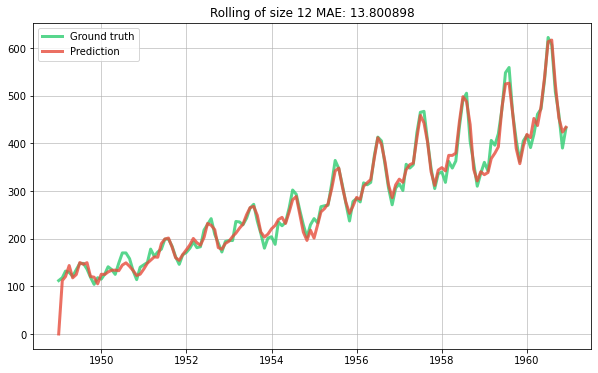

In [24]:
model = compose.Pipeline(
    (
        "features",
        compose.TransformerUnion(
            ("ordinal_date", compose.FuncTransformer(get_ordinal_date)),
            ("month_distances", compose.FuncTransformer(get_month_distances)),
        ),
    ),
    ("scale", preprocessing.StandardScaler()),
    (
        "lin_reg",
        linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03)),
    ),
)

model = time_series.Detrender(regressor=model, window_size=12)

evaluate_model(model)

We've managed to get a good looking prediction curve with a reasonably simple model. 

What's more our model has the advantage of being interpretable and easy to debug. There surely are more rocks to squeeze (e.g. tune the hyperparameters, use an ensemble model, etc.) but we'll leave that as an exercice to the reader.

### Pipeline syntax 

As a finishing touch we'll rewrite our pipeline using the `|` operator, which is called a "pipe".

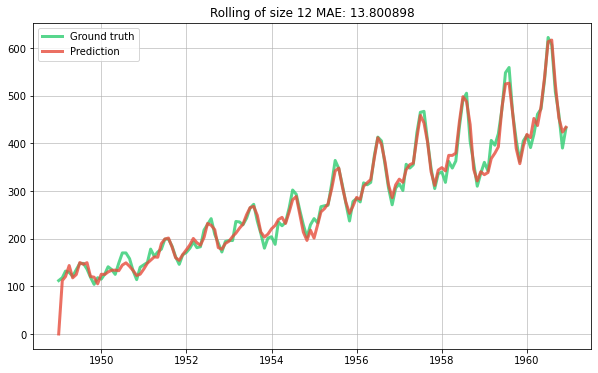

In [25]:
extract_features = compose.TransformerUnion(get_ordinal_date, get_month_distances)

scale = preprocessing.StandardScaler()

learn = linear_model.LinearRegression(intercept_lr=0, optimizer=optim.SGD(0.03))

model = extract_features | scale | learn
model = time_series.Detrender(regressor=model, window_size=12)

evaluate_model(model)

# SNARIMAX 

Instead of using Detrender and LinearRegression will use [SNARIMAX model](https://riverml.xyz/latest/api/time-series/SNARIMAX).

This method aims to predict a time series using the ARMA (autoregressivemoving average) model, under minimal assumptions on the noise terms.  
The prediction are made using an effective online learning algorithms which not assumes that the noise terms are Gaussian,  identically distributed or even independent. 

References
----------
[^1]: [Wikipedia page on ARMA](https://www.wikiwand.com/en/Autoregressive%E2%80%93moving-average_model)

[^2]: [Wikipedia page on NARX](https://www.wikiwand.com/en/Nonlinear_autoregressive_exogenous_model)

[^3]: [ARIMA models](https://otexts.com/fpp2/arima.html)

[^4]: [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June. Online learning for time series prediction. In Conference on learning theory (pp. 172-184)](https://arxiv.org/pdf/1302.6927.pdf)

```
Parameters
----------
p
    Order of the autoregressive part. This is the number of past target values that will be
    included as features.
d
    Differencing order.
q
    Order of the moving average part. This is the number of past error terms that will be
    included as features.
m
    Season length used for extracting seasonal features. If you believe your data has a
    seasonal pattern, then set this accordingly. For instance, if the data seems to exhibit
    a yearly seasonality, and that your data is spaced by month, then you should set this
    to 12. Note that for this parameter to have any impact you should also set at least one
    of the `p`, `d`, and `q` parameters.
sp
    Seasonal order of the autoregressive part. This is the number of past target values
    that will be included as features.
sd
    Seasonal differencing order.
sq
    Seasonal order of the moving average part. This is the number of past error terms that
    will be included as features.
regressor
    The online regression model to use. By default, a `preprocessing.StandardScaler`
    piped with a `linear_model.LinearRegression` will be used.
```

In [26]:
import calendar
import datetime as dt

from river import (
    compose,
    datasets,
    linear_model,
    metrics,
    optim,
    preprocessing,
    time_series,
)

In [27]:
class SNARIMAX_one(time_series.SNARIMAX):
    """Add `predict_one` method to SNARIMAX.
    TODO: open a PR for that.
    """
    def predict_one(self, x):
        return self.forecast(1, [x])[0]

In [28]:
extract_features = compose.TransformerUnion(get_ordinal_date, get_month_distances)

model = extract_features | SNARIMAX_one(
    p=0,
    d=0,
    q=0,
    m=12,
    sp=3,
    sq=6,
    regressor=(
        preprocessing.StandardScaler()
        | linear_model.LinearRegression(
            # intercept=110,
            optimizer=optim.SGD(0.01),
            intercept_lr=0.3,
        )
    ),
)

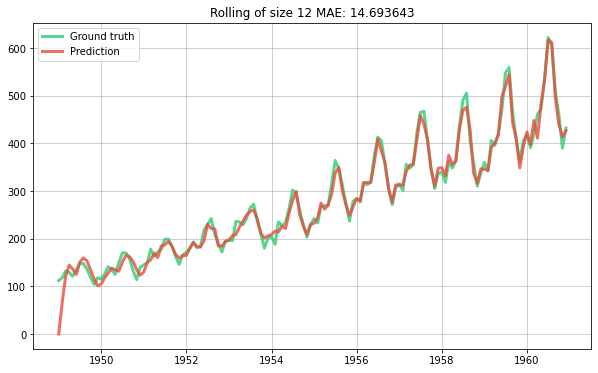

In [29]:
evaluate_model(model)

### Multihorizon prediction

<AxesSubplot:>

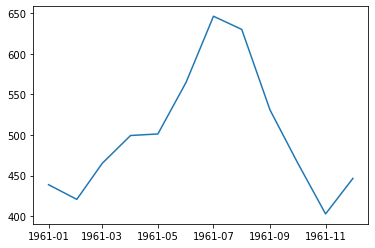

In [30]:
horizon = 12
future = [{"month": dt.date(year=1961, month=m, day=1)} for m in range(1, horizon + 1)]
forecast = model.forecast(horizon=horizon, xs=future)
forecast = pd.Series({x["month"]: y_pred for x, y_pred in zip(future, forecast)})
forecast.plot()

### Putting alltogether 

In [31]:
def evaluate_model_forecast(model):
    metric = metrics.Rolling(metrics.MAE(), 12)

    dates = []
    y_trues = []
    y_preds = []

    for x, y in datasets.AirlinePassengers():

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x["month"])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color="#2ecc71", alpha=0.8, label="Ground truth")
    ax.plot(dates, y_preds, lw=3, color="#e74c3c", alpha=0.8, label="Prediction")

    try:
        horizon = 12
        future = [
            {"month": dt.date(year=1961, month=m, day=1)} for m in range(1, horizon + 1)
        ]
        forecast = model.forecast(horizon=horizon, xs=future)
        ax.plot(
            [date["month"] for date in future],
            forecast,
            lw=3,
            color="#17becf",
            alpha=0.8,
            label="Forecast",
        )
    except AttributeError as err:
        print(err)

    ax.legend()
    ax.set_title(metric)

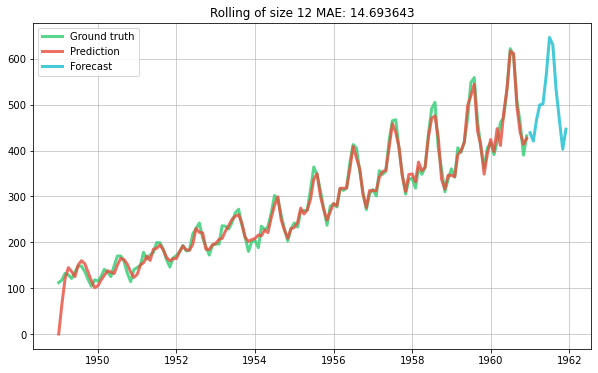

In [32]:
extract_features = compose.TransformerUnion(get_ordinal_date, get_month_distances)

model = extract_features | SNARIMAX_one(
    p=0,
    d=0,
    q=0,
    m=12,
    sp=3,
    sq=6,
    regressor=(
        preprocessing.StandardScaler()
        | linear_model.LinearRegression(
            # intercept=110,
            optimizer=optim.SGD(0.01),
            intercept_lr=0.3,
        )
    ),
)
evaluate_model_forecast(model)

In fact the SNARIMAX mode should not need to add month feature since it already have the feature to detect seasonalities.

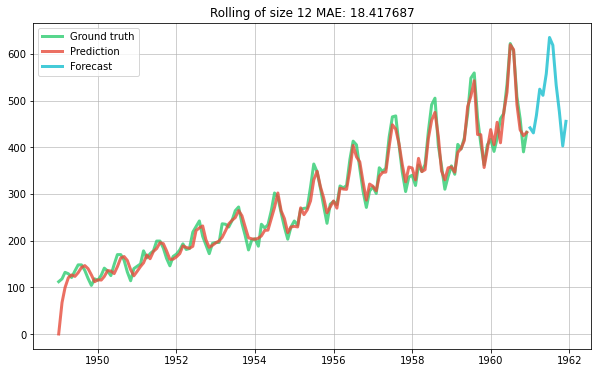

In [33]:
model = get_ordinal_date | SNARIMAX_one(
    p=0,
    d=0,
    q=0,
    m=12,
    sp=3,
    sq=6,
    regressor=(
        preprocessing.StandardScaler()
        | linear_model.LinearRegression(
            # intercept=110,
            optimizer=optim.SGD(0.01),
            intercept_lr=0.3,
        )
    ),
)
evaluate_model_forecast(model)

'LinearRegression' object has no attribute 'forecast'


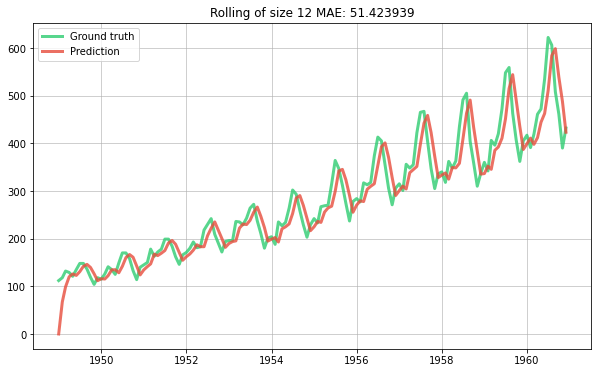

In [34]:
model = (
    get_ordinal_date
    | preprocessing.StandardScaler()
    | linear_model.LinearRegression(
        # intercept=110,
        optimizer=optim.SGD(0.01),
        intercept_lr=0.3,
    )
)

evaluate_model_forecast(model)